### Test notebook for Twitter Sentiment analysis 


((https://www.youtube.com/watch?v=4YGkfAd2iXM))

In [4]:
import os
import shutil

###### Kaggle dataset config

In [ ]:
# Configuration only if using Kaggle datasets
kaggle_dir = os.path.expanduser("~/.kaggle")
kaggle_json_path = 'C:/Users/dugara/Documents/GitHub-POC/SentimentAnalysis/kaggle.json'  # Adjust this if the file is elsewhere

# Ensure the directory exists, and copy the file
os.makedirs(kaggle_dir, exist_ok=True)  # Create .kaggle dir if it doesn't exist
shutil.copy(kaggle_json_path, kaggle_dir)  # Copy kaggle.json to the .kaggle directory


'C:\\Users\\dugara/.kaggle\\kaggle.json'

##### Extracting the dataset with twitter comments

In [2]:
import zipfile
import os

# Define paths
zip_file_path = '../Datasets/Zip/Twitter.zip'  # Adjust to your path
extract_dir = '../Datasets/Data/'  # Adjust to your desired directory

# Extract the dataset if it's in a zip file
if zip_file_path.endswith('.zip'):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Dataset extracted to {extract_dir}")
else:
    print("Dataset is already extracted.")

Dataset extracted to ../Datasets/Data/


##### Load the Dataset

In [3]:
import pandas as pd

# Path to the Sentiment140 dataset (adjust based on the extracted folder)
dataset_path = os.path.join(extract_dir, 'training.1600000.processed.noemoticon.csv')  # Change the file name if needed

# Load the dataset into a pandas DataFrame
df = pd.read_csv(dataset_path, encoding='latin1', header=None)

# Columns of the dataset
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Check the first few rows
print(df.head())


   target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


##### Cleaning the Text Data

In [18]:
import re

# Basic text cleaning function
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions (@user)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply the cleaning function to the text column
df['cleaned_text'] = df['text'].apply(clean_text)

# Show cleaned data
print(df[['text', 'cleaned_text']].head())


                                                text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  is upset that he can't update his Facebook by ...   
2  @Kenichan I dived many times for the ball. Man...   
3    my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all....   

                                        cleaned_text  
0     a thats a bummer  you shoulda got david car...  
1  is upset that he cant update his facebook by t...  
2   i dived many times for the ball managed to sa...  
3    my whole body feels itchy and like its on fire   
4   no its not behaving at all im mad why am i he...  


##### Sentiment Analysis using VADER

In [21]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment using VADER
def get_vader_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)['compound']
    return 4 if sentiment_score >= 0 else 0  # 4 for positive, 0 for negative

# Apply VADER sentiment analysis
df['vader_sentiment'] = df['cleaned_text'].apply(get_vader_sentiment)

# Check results
print(df[['cleaned_text', 'vader_sentiment']].head())


                                        cleaned_text  vader_sentiment
0     a thats a bummer  you shoulda got david car...                0
1  is upset that he cant update his facebook by t...                0
2   i dived many times for the ball managed to sa...                4
3    my whole body feels itchy and like its on fire                 0
4   no its not behaving at all im mad why am i he...                0


##### Sentiment Analysis using RoBERTa

In [45]:
import torch
import os
import certifi
import ssl
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# SSL Configuration
def configure_ssl():
    """Configure SSL certificates and environment variables"""
    os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()
    os.environ['SSL_CERT_FILE'] = certifi.where()
    ssl._create_default_https_context = ssl._create_unverified_context

def setup_roberta(offline_mode=False):
    """Initialize RoBERTa model and tokenizer with SSL handling"""
    configure_ssl()
    
    try:
        # First attempt: Standard loading with SSL fixes
        tokenizer = AutoTokenizer.from_pretrained(
            'roberta-base',
            use_auth_token=True,  # If you have a Hugging Face token
            local_files_only=offline_mode
        )
        model = AutoModelForSequenceClassification.from_pretrained(
            'roberta-base',
            use_auth_token=True,
            local_files_only=offline_mode
        )
    except Exception as e:
        print(f"First attempt failed: {str(e)}")
        print("Trying alternative loading method...")
        
        # Second attempt: Using cache directory
        cache_dir = os.path.expanduser("~/.cache/huggingface/transformers")
        tokenizer = AutoTokenizer.from_pretrained(
            'roberta-base',
            cache_dir=cache_dir,
            local_files_only=True
        )
        model = AutoModelForSequenceClassification.from_pretrained(
            'roberta-base',
            cache_dir=cache_dir,
            local_files_only=True
        )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return tokenizer, model, device

def get_roberta_sentiment(text, tokenizer, model, device):
    """Get sentiment prediction for a single text"""
    try:
        inputs = tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        probabilities = torch.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
        confidence = probabilities.max().item()
        
        return prediction, confidence
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return 0, 0.0  # Default values in case of error

def analyze_sentiment(df, offline_mode=False):
    """Process the DataFrame with RoBERTa sentiment analysis"""
    # Setup with SSL handling
    tokenizer, model, device = setup_roberta(offline_mode)
    model.eval()
    
    results = []
    
    # Process in smaller batches
    batch_size = 16  # Reduced batch size for stability
    
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df['cleaned_text'].iloc[i:i+batch_size]
        batch_results = []
        
        for text in batch:
            if isinstance(text, str):
                pred, conf = get_roberta_sentiment(text, tokenizer, model, device)
                batch_results.append((pred, conf))
            else:
                batch_results.append((0, 0.0))  # Default for invalid text
                
        results.extend(batch_results)
    
    # Unpack results
    predictions, confidences = zip(*results)
    
    # Add to DataFrame
    df['roberta_sentiment'] = predictions
    df['roberta_confidence'] = confidences
    
    return df

# Example usage
if __name__ == "__main__":
    import pandas as pd
    
    try:
        # Try online mode first
        df = analyze_sentiment(df)
    except Exception as e:
        print(f"Online mode failed: {str(e)}")
        print("Trying offline mode...")
        # Fall back to offline mode
        df = analyze_sentiment(df, offline_mode=True)
    
    print(df[['cleaned_text', 'roberta_sentiment', 'roberta_confidence']].head())

c:\Users\dugara\Documents\GitHub-POC\SentimentAnalysis\venv\Lib\site-packages\transformers\models\auto\tokenization_auto.py:823: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
c:\Users\dugara\Documents\GitHub-POC\SentimentAnalysis\venv\Lib\site-packages\transformers\models\auto\auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


First attempt failed: (MaxRetryError("HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Max retries exceeded with url: /roberta-base/5bde1d28afb363d0103324efeb5afc8b2b397fe5e04beabb9b1ef355255ade81?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1739273979&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczOTI3Mzk3OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yb2JlcnRhLWJhc2UvNWJkZTFkMjhhZmIzNjNkMDEwMzMyNGVmZWI1YWZjOGIyYjM5N2ZlNWUwNGJlYWJiOWIxZWYzNTUyNTVhZGU4MT9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=KdqkKoVYHPHQ4EH3JUqlRZuFrg15k8s8su3NRAwqq3sl4totMMz-Gl7~-OZKDaT2nLfDzgjJ4RWY2wHD3lHhnIHuXOk9caaDi3KVntWdxGhLqNQRa5z0mSrNMk3eHk06GHrNH4bsw7YvljDMB9xYda~YZ33N5uMHuXO25oNS1YSNUMR6cJJxeOSKt2QaOQoaX~tBeeReMYNOgvUAT~eNL~ZCCHjaEintFaHzBXExQ9pUjx1YxEiw9TrfXsy2PYdU1yXRRWFjSTq5VRmMY76g5e84b9QMk7mA6AdvNTJqsQxzGlsmVAdvAXkNDVMypym6wZkv0WDstxgquhUz9SjA1A__&Key-

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like roberta-base is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

##### Using DistilBERT for Sentiment Analysis

In [49]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Load the tokenizer and model for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Ensure you're using the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to predict sentiment using DistilBERT
def get_distilbert_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()  # 0 = negative, 1 = positive
    return prediction

# Apply DistilBERT sentiment analysis
df['distilbert_sentiment'] = df['cleaned_text'].apply(get_distilbert_sentiment)

# Check results
print(df[['cleaned_text', 'distilbert_sentiment']].head())


SSLError: (MaxRetryError("HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Max retries exceeded with url: /distilbert-base-uncased/5e3f1108e3cb34ee048634875d8482665b65ac713291a7e32396fb18f6ff0063?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1739274959&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczOTI3NDk1OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kaXN0aWxiZXJ0LWJhc2UtdW5jYXNlZC81ZTNmMTEwOGUzY2IzNGVlMDQ4NjM0ODc1ZDg0ODI2NjViNjVhYzcxMzI5MWE3ZTMyMzk2ZmIxOGY2ZmYwMDYzP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=HXolUBBxal4pqT9e-e1qrh9RElghgulvkZ8-uHz9jEABwkUpebjemnx5wbrcfIKfv8oSWJMKM2E9RWedgAS7NqcT1pxS8vx0ZVIeEm9FNYxk7dlZzRRVu8Jqfmi1eVYrZAjFP9l2By8MHGl-lzEOZ0iWkshh43ABHvHXjMkX6jJ6JEPAzm1IaEB-M6mb-L0iLvmlEiGBW~2YGm32m8tQXecCT03c4yykIDiTTL7CxIUlVcKimHJYMCGA~VIpQboVJfDbT0XTBDGK2W3VyjNL3AsbCPjHhNCV7gorXgK5goEcsIyh9cokhmgI94LWfIqEb19l1bgT6X4~wIHt8cacnQ__&Key-Pair-Id=K3RPWS32NSSJCE (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)')))"), '(Request ID: 508952a3-6f7d-4b3a-945c-214d291e9127)')

##### Text Blob

In [22]:
from textblob import TextBlob

# Function to classify sentiment using TextBlob
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity  # Returns a score between -1 (negative) and 1 (positive)
    return 4 if sentiment_score >= 0 else 0  # 4 for positive, 0 for negative

# Apply TextBlob sentiment analysis
df['textblob_sentiment'] = df['cleaned_text'].apply(get_textblob_sentiment)

# Check results
print(df[['cleaned_text', 'textblob_sentiment']].head())


                                        cleaned_text  textblob_sentiment
0     a thats a bummer  you shoulda got david car...                   4
1  is upset that he cant update his facebook by t...                   4
2   i dived many times for the ball managed to sa...                   4
3    my whole body feels itchy and like its on fire                    4
4   no its not behaving at all im mad why am i he...                   0


##### Evaluate the Performance Vader vs TextBlob

Accuracy of VADER: 0.6636
Accuracy of TextBlob: 0.6071


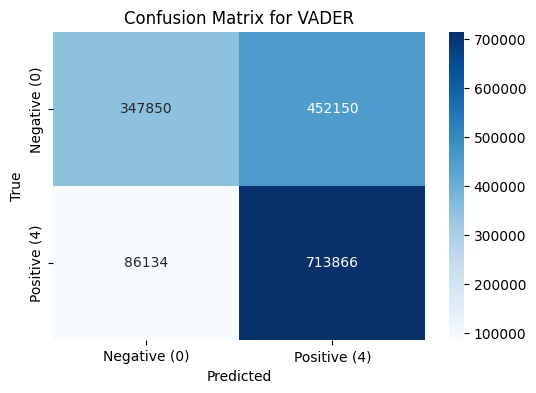

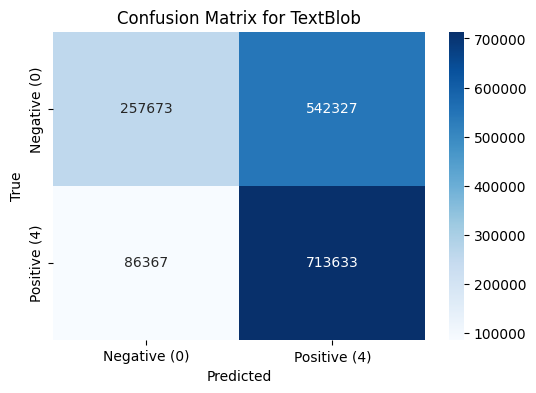


Classification Report for VADER:
              precision    recall  f1-score   support

Negative (0)       0.80      0.43      0.56    800000
Positive (4)       0.61      0.89      0.73    800000

    accuracy                           0.66   1600000
   macro avg       0.71      0.66      0.64   1600000
weighted avg       0.71      0.66      0.64   1600000


Classification Report for TextBlob:
              precision    recall  f1-score   support

Negative (0)       0.75      0.32      0.45    800000
Positive (4)       0.57      0.89      0.69    800000

    accuracy                           0.61   1600000
   macro avg       0.66      0.61      0.57   1600000
weighted avg       0.66      0.61      0.57   1600000


Detailed Metrics:

VADER:
True Negatives (Correctly predicted 0): 347850
False Positives (Predicted 4 but was 0): 452150
False Negatives (Predicted 0 but was 4): 86134
True Positives (Correctly predicted 4): 713866

TextBlob:
True Negatives (Correctly predicted 0): 257673
F

In [36]:
# FIRST NOTEBOOK/CELL - Model Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate accuracy scores
accuracy_vader = accuracy_score(df['target'], df['vader_sentiment'])
accuracy_textblob = accuracy_score(df['target'], df['textblob_sentiment'])

# Print accuracy scores
print(f"Accuracy of VADER: {accuracy_vader:.4f}")
print(f"Accuracy of TextBlob: {accuracy_textblob:.4f}")

# Create and plot confusion matrix for VADER
plt.figure(figsize=(6, 4))
conf_matrix_vader = confusion_matrix(df['target'], df['vader_sentiment'], labels=[0, 4])
sns.heatmap(conf_matrix_vader, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Negative (0)', 'Positive (4)'], 
            yticklabels=['Negative (0)', 'Positive (4)'])
plt.title("Confusion Matrix for VADER")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Create and plot confusion matrix for TextBlob
plt.figure(figsize=(6, 4))
conf_matrix_textblob = confusion_matrix(df['target'], df['textblob_sentiment'], labels=[0, 4])
sns.heatmap(conf_matrix_textblob, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Negative (0)', 'Positive (4)'], 
            yticklabels=['Negative (0)', 'Positive (4)'])
plt.title("Confusion Matrix for TextBlob")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print classification reports with proper labels
print("\nClassification Report for VADER:")
print(classification_report(df['target'], df['vader_sentiment'], 
                          labels=[0, 4],
                          target_names=['Negative (0)', 'Positive (4)']))

print("\nClassification Report for TextBlob:")
print(classification_report(df['target'], df['textblob_sentiment'], 
                          labels=[0, 4],
                          target_names=['Negative (0)', 'Positive (4)']))

# Calculate additional metrics for both models
print("\nDetailed Metrics:")
print("\nVADER:")
tn_vader, fp_vader, fn_vader, tp_vader = confusion_matrix(df['target'], df['vader_sentiment'], labels=[0, 4]).ravel()
print(f"True Negatives (Correctly predicted 0): {tn_vader}")
print(f"False Positives (Predicted 4 but was 0): {fp_vader}")
print(f"False Negatives (Predicted 0 but was 4): {fn_vader}")
print(f"True Positives (Correctly predicted 4): {tp_vader}")

print("\nTextBlob:")
tn_textblob, fp_textblob, fn_textblob, tp_textblob = confusion_matrix(df['target'], df['textblob_sentiment'], labels=[0, 4]).ravel()
print(f"True Negatives (Correctly predicted 0): {tn_textblob}")
print(f"False Positives (Predicted 4 but was 0): {fp_textblob}")
print(f"False Negatives (Predicted 0 but was 4): {fn_textblob}")
print(f"True Positives (Correctly predicted 4): {tp_textblob}")

##### Visualize the Sentiment Distribution Vader vs TextBlob

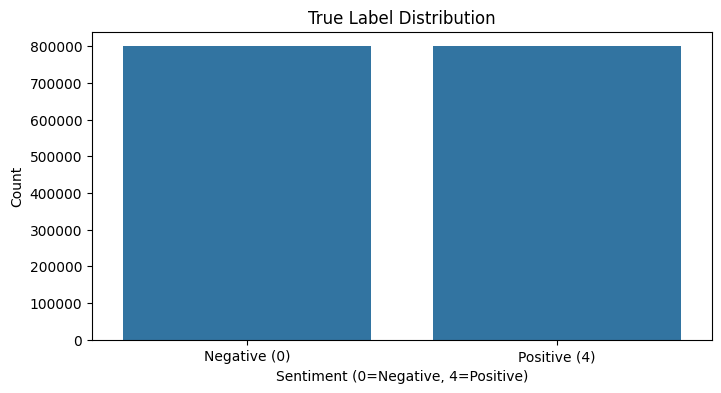

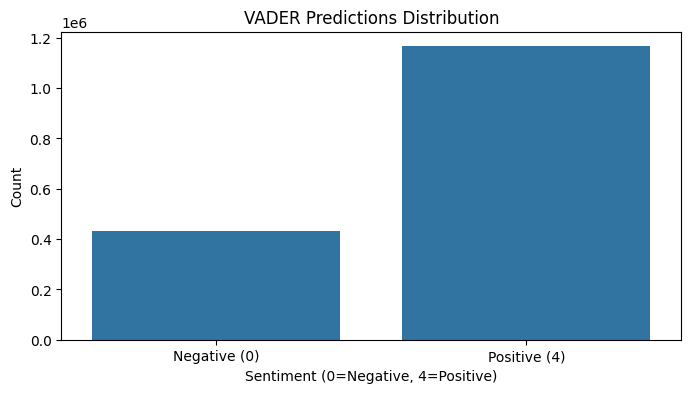

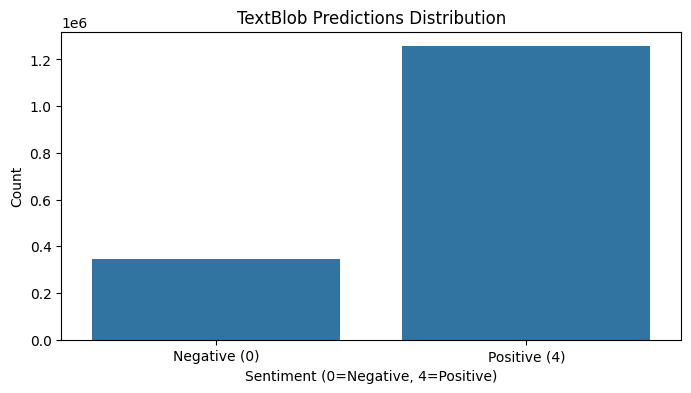

=== Distribution Counts ===

True Labels:
target
0    800000
4    800000
Name: count, dtype: int64

VADER Predictions:
vader_sentiment
0     433984
4    1166016
Name: count, dtype: int64

TextBlob Predictions:
textblob_sentiment
0     344040
4    1255960
Name: count, dtype: int64

=== Model Agreement ===
VADER and TextBlob agree on 80.5% of predictions


In [35]:
# SECOND NOTEBOOK/CELL - Basic Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot sentiment distributions
def plot_distribution(data, column, title):
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=column, order=[0, 4])
    plt.title(title)
    plt.xlabel('Sentiment (0=Negative, 4=Positive)')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Negative (0)', 'Positive (4)'])
    plt.show()

# Plot distributions for both models and true values
plot_distribution(df, 'target', 'True Label Distribution')
plot_distribution(df, 'vader_sentiment', 'VADER Predictions Distribution')
plot_distribution(df, 'textblob_sentiment', 'TextBlob Predictions Distribution')

# 2. Print simple counts
print("=== Distribution Counts ===")
print("\nTrue Labels:")
print(df['target'].value_counts().sort_index())

print("\nVADER Predictions:")
print(df['vader_sentiment'].value_counts().sort_index())

print("\nTextBlob Predictions:")
print(df['textblob_sentiment'].value_counts().sort_index())

# 3. Calculate and print model agreement
agreement = (df['vader_sentiment'] == df['textblob_sentiment']).mean() * 100
print(f"\n=== Model Agreement ===")
print(f"VADER and TextBlob agree on {agreement:.1f}% of predictions")

##### Evaluate the Performance Vader vs Roberta

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compare VADER and RoBERTa sentiment predictions with the ground truth
accuracy_vader = accuracy_score(df['target'], df['vader_sentiment_label'])
accuracy_roberta = accuracy_score(df['target'], df['roberta_sentiment'])

# Print accuracy scores
print(f"Accuracy of VADER: {accuracy_vader}")
print(f"Accuracy of RoBERTa: {accuracy_roberta}")

# Confusion matrix for VADER
conf_matrix_vader = confusion_matrix(df['target'], df['vader_sentiment_label'])
sns.heatmap(conf_matrix_vader, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for VADER")
plt.show()

# Confusion matrix for RoBERTa
conf_matrix_roberta = confusion_matrix(df['target'], df['roberta_sentiment'])
sns.heatmap(conf_matrix_roberta, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for RoBERTa")
plt.show()

# Detailed classification report for VADER
print("Classification Report for VADER:")
print(classification_report(df['target'], df['vader_sentiment_label']))

# Detailed classification report for RoBERTa
print("Classification Report for RoBERTa:")
print(classification_report(df['target'], df['roberta_sentiment']))


##### Visualize the Sentiment Distribution Vader vs Roberta

In [ ]:
# Visualize the sentiment distribution predicted by VADER and RoBERTa
sns.countplot(x='vader_sentiment_label', data=df, palette='Blues')
plt.title('VADER Sentiment Prediction Distribution')
plt.show()

sns.countplot(x='roberta_sentiment', data=df, palette='Blues')
plt.title('RoBERTa Sentiment Prediction Distribution')
plt.show()
